In [2]:
from matplotlib import pyplot as plt
import torch
import numpy as np
from scipy import stats
import math
from typing import List, Tuple, Any, Optional, Dict
import sqlite3
import os
import pandas as pd

In [3]:
def plot_tests_vs(tests_acromym, value, prefix="", focus_dict = None, table_name="results"):
    """
    Creates the image of a grid of the global/local transformation between dstributions
    """
    plt.figure(figsize=(10,6))

    #creating the grid for the plot
    size = len(tests_acromym)
    grid = np.zeros((size, size))

    for i, global_name in enumerate(tests_acromym):
        for j, local_name in enumerate(tests_acromym):
            database_path = os.path.join("Databases", f"database_{prefix}{global_name}2{local_name}.db")

            try:
                # Use context manager for database connection
                with sqlite3.connect(database_path) as conn:
                    
                    if focus_dict is None: # If focus = None then we consider all the available values
                        cursor = conn.cursor()

                        # Fetching all the values from the table
                        query = f"SELECT {value} FROM {table_name}"
                        cursor.execute(query)
                    
                        results = cursor.fetchall()

                        # Convert results to numpy arrays
                        x_list = []
                        for row in results:
                            if (row[0] is not None):
                                x_list.append(float(row[0]))
                            else:
                                print("one None found")
                        x_array = np.array(x_list)

                    else:
                        df = pd.read_sql("table_name", conn)
                        mask = pd.Series(True, index=df.index)
                        
                        for column, values in focus_dict.items():
                            mask &= df[column].isin(values)
                        
                        # Obtaining all the values that follow the focus requirement
                        values_list = df[mask]['value'].tolist()

                        x_list = []
                        for x in values_list:
                            if x is not None:
                                x_list.append(x)
                            else:
                                print("one None found")

                        # Converting into the numpy array
                        x_array = np.array(x_list)

                grid[i][j] = np.average(x_array)

            except sqlite3.Error as e:
                print(f"Database error: {e}")
            except Exception as e:
                print(f"Error: {e}")

    # Plot the grid with proper configuration
    plt.figure(figsize=(10, 6))
    im = plt.imshow(grid, cmap='viridis', aspect='equal')
    
    # Add colorbar
    plt.colorbar(im, label=value)
    
    # Add labels and ticks
    plt.xticks(range(size), tests_acromym, rotation=45)
    plt.yticks(range(size), tests_acromym)
    
    # Add labels for axes
    plt.xlabel('Local Distribution')
    plt.ylabel('Global Distribution')
    
    # Add title
    plt.title(f'Local Trasformation - {value}')
    
    # Adjust layout to prevent label cutoff
    plt.tight_layout()
    print(grid)
                
            


def plot_database_columns(test_names, x_column, y_column, table_name="results", z_column=None, focus=None):
    """
    Create a scatter plot from two columns in a SQLite database table.
    
    Parameters:
    test_names (list): List of names of the tests to be plotted
    x_column (str): Name of the column to plot on x-axis
    y_column (str): Name of the column to plot on y-axis
    table_name (str): Name of the table in the database
    z_column (str, optional): Name of column to filter on
    focus (list, optional): List of values to filter z_column by
    """

    # Create figure once, outside the loop
    plt.figure(figsize=(8, 4))
    # Create a list of colors for different tests
    colors = ['b', 'r', 'g', 'c', 'm', 'y', 'k']
    # Store statistics for all tests
    stats_summary = {}

    for idx, test_name in enumerate(test_names):

        # Select the right database and color for the plotting
        color = colors[idx % len(colors)]  # Cycle through colors if more tests than colors
        database_path = os.path.join("Databases", f"database_{test_name}.db")

        try:
            # Use context manager for database connection
            with sqlite3.connect(database_path) as conn:
                cursor = conn.cursor()
                
                # Create a query to select the desired columns with optional filtering
                if z_column and focus:
                    # Convert the focus list to string for SQL IN clause
                    focus_str = ', '.join('?' * len(focus))
                    # No need for separate column selection if column_z is x_column or y_column
                    query = f"""
                        SELECT DISTINCT {x_column}, {y_column}
                        FROM {table_name}
                        WHERE {z_column} IN ({focus_str})
                    """
                    # Execute with parameters
                    cursor.execute(query, focus)
                else:
                    query = f"SELECT {x_column}, {y_column} FROM {table_name}"
                    cursor.execute(query)
                
                results = cursor.fetchall()
                
                if not results:
                    print("No data found matching the specified criteria.")
                    return
            
            # Convert results to numpy arrays
            x_list = []
            y_list = []
            for row in results:
                if (row[0] is not None) and (row[1] is not None):
                    x_list.append(float(row[0]))
                    y_list.append(float(row[1]))
                else:
                    print("one None found")
            x_array = np.array(x_list)
            y_array = np.array(y_list)
            
            # Check if all x values are identical
            if np.all(x_array == x_array[0]):
                # All x values are identical, plot a horizontal line at mean of y
                y_mean = np.mean(y_array)
                
                # Create the scatter plot
                plt.scatter(x_array, y_array, alpha=0.3, color=color, s=5)
                
                # Plot horizontal line at y mean
                plt.axhline(y=y_mean, color=color, linestyle='-', 
                            label=f"{test_name} (mean={y_mean:.4f})")
                
                # Store statistics
                stats_summary[test_name] = {
                    'x_value': x_array[0],
                    'y_mean': y_mean,
                    'y_std': np.std(y_array),
                    'sample_size': len(y_array)
                }
            else:
                # Normal case - calculate regression line
                slope, intercept, r_value, p_value, std_err = stats.linregress(x_array, y_array)
                
                # Create points for regression line
                line_x = np.array([x_array.min(), x_array.max()]).reshape(-1, 1)
                line_y = slope * line_x + intercept

                # Store statistics
                stats_summary[test_name] = {
                    'slope': slope,
                    'intercept': intercept,
                    'r_squared': r_value**2,
                    'p_value': p_value,
                    'std_err': std_err,
                    'regression': True
                }
                
                # Create the scatter plot
                plt.scatter(x_array, y_array, alpha=0.3, color=color, s=5)
                
                # Plot regression line
                plt.plot(line_x, line_y, linestyle='-', label=f"{test_name}", color=color)
                        
        except sqlite3.Error as e:
            print(f"Database error: {e}")
        except Exception as e:
            print(f"Error: {e}")

    # Customize the plot (only once, after all tests are plotted)
    plt.xlabel(x_column)
    plt.ylabel(y_column)
    title = f'{y_column} vs {x_column}'
    if z_column and focus:
        title += f'\n(filtered {z_column} in {focus})'
    plt.title(title)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend()

    # Print detailed statistics
    print("\nStatistics Summary:")
    print("-" * 50)
    for test_name, stats_dict in stats_summary.items():
        print(f"\n{test_name}:")
        if stats_dict.get('regression', False):
            print(f"Equation: y = {stats_dict['slope']:.4f}x + {stats_dict['intercept']:.4f}")
            print(f"R² = {stats_dict['r_squared']:.4f}")
            print(f"p-value = {stats_dict['p_value']:.4e}")
            print(f"Standard Error = {stats_dict['std_err']:.4f}")
        else:
            print(f"Constant x value: {stats_dict['x_value']}")
            print(f"Mean y value: {stats_dict['y_mean']:.4f}")
            print(f"Standard deviation: {stats_dict['y_std']:.4f}")
            print(f"Sample size: {stats_dict['sample_size']}")

    # Show the plot (only once, after everything is done)
    plt.show()



def analyze_column_correlations(
    test_names: List[str],
    column_x: str,
    column_y1: str,
    column_y2: str,
    table_name: str = "results",
    focus_dict: Optional[Dict] = None,
    figsize: Tuple[int, int] = (15, 5)
) -> None:
    """
    Analyze and visualize the correlation between two columns (Y1 and Y2) 
    averaged over different values of a grouping column (X).
    
    Parameters:
    -----------
    test_names : List[str]
        List of test names to analyze
    column_x : str
        Name of the column to group by (typically base_xi_id or phi_id)
    column_y1 : str
        Name of the first column to analyze
    column_y2 : str
        Name of the second column to analyze
    table_name : str
        Name of the database table
    focus_dict : Optional[Dict]
        Dictionary of column-value pairs to filter the data
    figsize : Tuple[int, int]
        Size of the figure to create
    """
    # Create figure with three subplots
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=figsize)
    
    # Colors for different tests
    colors = ['b', 'r', 'g', 'c', 'm', 'y', 'k']
    
    # Store statistics for all tests
    stats_summary = {}
    
    for idx, test_name in enumerate(test_names):
        color = colors[idx % len(colors)]
        database_path = os.path.join("Databases", f"database_{test_name}.db")
        
        try:
            with sqlite3.connect(database_path) as conn:
                # Read the entire table into a pandas DataFrame
                df = pd.read_sql_query(f"SELECT * FROM {table_name}", conn)
                
                # Apply filters if focus_dict is provided
                if focus_dict:
                    for col, values in focus_dict.items():
                        df = df[df[col].isin(values)]
                
                # Group by column_x and calculate means for both Y columns
                grouped_means = df.groupby(column_x).agg({
                    column_y1: 'mean',
                    column_y2: 'mean'
                }).reset_index()
                
                # Plot Y1 vs X
                ax1.scatter(grouped_means[column_x], 
                          grouped_means[column_y1],
                          alpha=0.6, color=color, label=test_name)
                
                # Plot Y2 vs X
                ax2.scatter(grouped_means[column_x], 
                          grouped_means[column_y2],
                          alpha=0.6, color=color, label=test_name)
                
                # Plot Y2 vs Y1
                ax3.scatter(grouped_means[column_y1], 
                          grouped_means[column_y2],
                          alpha=0.6, color=color, label=test_name)
                
                # Calculate correlation statistics
                slope, intercept, r_value, p_value, std_err = stats.linregress(
                    grouped_means[column_y1],
                    grouped_means[column_y2]
                )
                
                # Plot regression line for Y2 vs Y1
                line_x = np.array([grouped_means[column_y1].min(), 
                                 grouped_means[column_y1].max()])
                line_y = slope * line_x + intercept
                ax3.plot(line_x, line_y, '--', color=color, alpha=0.5)
                
                # Store statistics
                stats_summary[test_name] = {
                    'slope': slope,
                    'intercept': intercept,
                    'r_squared': r_value**2,
                    'p_value': p_value,
                    'std_err': std_err,
                    'n_points': len(grouped_means)
                }
                
        except sqlite3.Error as e:
            print(f"Database error for {test_name}: {e}")
        except Exception as e:
            print(f"Error processing {test_name}: {e}")
    
    # Customize plots
    ax1.set_xlabel(column_x)
    ax1.set_ylabel(column_y1)
    ax1.set_title(f'Average {column_y1} vs {column_x}')
    ax1.grid(True, alpha=0.3)
    ax1.legend()
    
    ax2.set_xlabel(column_x)
    ax2.set_ylabel(column_y2)
    ax2.set_title(f'Average {column_y2} vs {column_x}')
    ax2.grid(True, alpha=0.3)
    ax2.legend()
    
    ax3.set_xlabel(f'Average {column_y1}')
    ax3.set_ylabel(f'Average {column_y2}')
    ax3.set_title(f'Average {column_y2} vs Average {column_y1}')
    ax3.grid(True, alpha=0.3)
    ax3.legend()
    
    plt.tight_layout()
    
    # Print statistical summary
    print("\nCorrelation Statistics:")
    print("-" * 60)
    for test_name, stats_dict in stats_summary.items():
        print(f"\n{test_name}:")
        print(f"Number of unique {column_x} values: {stats_dict['n_points']}")
        print(f"Correlation equation: y = {stats_dict['slope']:.4f}x + {stats_dict['intercept']:.4f}")
        print(f"R² = {stats_dict['r_squared']:.4f}")
        print(f"p-value = {stats_dict['p_value']:.4e}")
        print(f"Standard Error = {stats_dict['std_err']:.4f}")
    
    return fig, stats_summary

Database error: no such table: results

Statistics Summary:
--------------------------------------------------


/tmp/ipykernel_14305/831508383.py:210: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


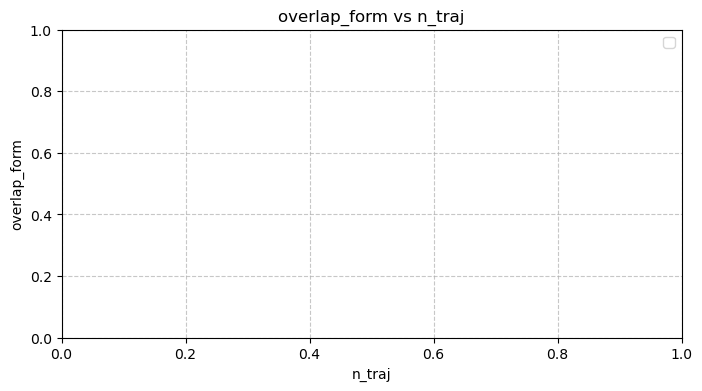

In [19]:
#['n_psi_added', 'n_traj', 'local_std', 'n_traj_points', 'Dist', 'Cos_Dist', 'Dist_rho', 'Norm_glob', 'Norm_loc', 'Norm_imp', 'Pinv_error', 'Sum_weights', 'Sum_squared_weights', 'Elapsed_time', 'Process_mem']
#[n_psi_added n_traj local_std n_traj_points phi_id base_xi_id Dist Cos_Dist Dist_rho Norm_glob Norm_loc Norm_imp Pinv_error Sum_weights Sum_squared_weights Elapsed_time Process_mem n_e
# weight_strategy, n_psi_added, n_traj, target_std, proposal_std, n_traj_points, phi_id, base_xi_id, Dist, Cos_dist, Dist_rho, Norm_proposal, Norm_target, Norm_imp,Pinv_error, Sum_weights, Sum_squared_weights, Elapsed_time, Process_mem, n_e, overlap_form, dist_form
test_names = ["AmodelM2M"]
x_column = "n_traj"
y_column = "overlap_form"
table_name = "results"

z_column = None#"local_std"
focus = None#[1]

plot_database_columns(test_names, x_column, y_column, table_name, z_column=z_column, focus=focus)


Statistics Summary:
--------------------------------------------------

onlytarget_pure_M2M:
Equation: y = -0.0001x + 1.1648
R² = 0.1677
p-value = 2.4601e-02
Standard Error = 0.0000

onlytarget_pure_B2M:
Equation: y = -0.0000x + 0.7687
R² = 0.0100
p-value = 5.9824e-01
Standard Error = 0.0000

onlytarget_pure_G2M:
Equation: y = -0.0001x + 0.9679
R² = 0.1594
p-value = 2.8830e-02
Standard Error = 0.0000

onlytarget_pure_H2M:
Equation: y = -0.0000x + 0.8177
R² = 0.0562
p-value = 2.0719e-01
Standard Error = 0.0000

onlytarget_pure_T2M:
Equation: y = -0.0000x + 0.1851
R² = 0.0000
p-value = 9.8445e-01
Standard Error = 0.0000


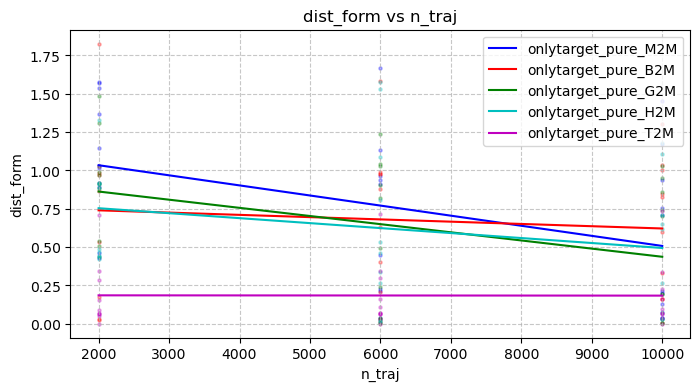

In [21]:
#weight_strategy, n_psi_added, n_traj, target_std, proposal_std, n_traj_points, phi_id, base_xi_id, Dist, Cos_dist, Dist_rho, Norm_proposal, Norm_target, Norm_imp, Pinv_error, Sum_weights, Sum_squared_weights, Elapsed_time, Process_mem, n_e, overlap_form, dist_form, dist_new_kernels, dist_embed ))
            
"""#GeneralTestmu0_M2M: This shows the general behaviour of MU0 when we change the paramethers
test_names = ["GeneralTestmu0_M2M"]
y_column = "dist"
table_name = "results"
params = ["mu0", "mu1", "sigma1", "q"]

z_column = "q"
focus = [0.1]#["self_norm"]#["only_target"]#["self_norm"]
"""


""" GeneralTestOther_B2M: This shows the behaviour of other distributions and other weight strategy. Apparently it didn't work well.
test_names = ["GeneralTestOther_B2M", "GeneralTestOther_G2M", "GeneralTestOther_H2M", "GeneralTestOther_M2M", "GeneralTestOther_S2M", "GeneralTestOther_T2M"]
y_column = "dist_form"
table_name = "results"
params = ["phi_id"]

z_column = "weight_strategy"
focus = ["only_target"]#["self_norm"]#["square_root"]#
"""
"""
#selfnorm_V_q_M2M: This highlights the effect of the parameter q on the results. It shows how a high number of derivatives sign changes influences the results (n_e collapses)
test_names = ["selfnorm_V_q_M2M"]
y_column = "n_e"
table_name = "results"
params = ["n_traj", "q"]

z_column = None#"q"
focus = None#[0.1]#["self_norm"]#["only_target"]#["self_norm"]
"""

"""# selfnorm_V_mu1_M2M: This parameter does'n influence much the results. That's good so that I can show what really influences the results
test_names = ["selfnorm_V_mu1_M2M"]
y_column = "n_e"
table_name = "results"
params = ["n_traj", "mu1"]

z_column = None#"q"
focus = None#[0.1]#["self_norm"]#["only_target"]#["self_norm"]
"""

"""# selfnorm_V_mu0_M2M: This is another test where changing a parameter doesn't change a lot the results. 
# This suggests that some kind of 'local' transformations are possible!
test_names = ["selfnorm_V_mu0_M2M"]
y_column = "model_to_imp"
table_name = "results"
params = ["n_traj", "mu0"]

z_column = None#"q"
focus = None#[0.1]#["self_norm"]#["only_target"]#["self_norm"]
"""

"""# selfnorm_V_sigma0_M2M: still: small changes to the variations of the parameters. 
# I also note that while the increasing number of traj improvese dist, it doesn't improve dist_form
test_names = ["selfnorm_V_sigma0_M2M"]
y_column = "model_to_imp"
table_name = "results"
params = ["n_traj", "proposal_std"]

z_column = None#"q"
focus = None#[0.1]#["self_norm"]#["only_target"]#["self_norm"]
"""

"""#selfnorm_V_sigma1_M2M: same
test_names = ["selfnorm_V_sigma1_M2M"]
y_column = "dist_form"
table_name = "results"
params = ["n_traj", "sigma1"]

z_column = None#"q"
focus = None#[0.1]#["self_norm"]#["only_target"]#["self_norm"]
"""

# onlytarget_pure: This shows that we lack total generalization, only the distribution T (Traslation(a straight line)) works 
# correctly, showing the high bias of mu_0 for trajectories with low variation
test_names = ["onlytarget_pure_M2M", "onlytarget_pure_B2M", "onlytarget_pure_G2M", "onlytarget_pure_H2M", "onlytarget_pure_T2M"]
y_column = "dist_form"
table_name = "results"
params = ["n_traj"]

z_column = None#"q"
focus = None#[0.1]#["self_norm"]#["only_target"]#["self_norm"]


for x_column in params:
    plot_database_columns(test_names, x_column, y_column, table_name, z_column=z_column, focus=focus)


one None found
one None found
one None found
one None found
one None found
one None found
one None found
one None found
one None found
one None found
one None found
one None found
one None found
one None found
one None found
one None found
one None found
one None found
one None found
one None found
one None found
one None found
one None found
one None found
one None found
one None found
one None found
one None found
one None found
one None found
one None found
one None found
one None found
one None found
one None found
one None found
one None found
one None found
one None found
one None found
one None found
one None found
one None found
one None found
one None found
one None found
one None found
one None found
one None found
one None found
one None found
one None found
one None found
one None found
one None found
one None found
one None found
one None found
one None found
one None found
one None found
one None found
one None found
one None found
one None found
one None found
one None f

<Figure size 1000x600 with 0 Axes>

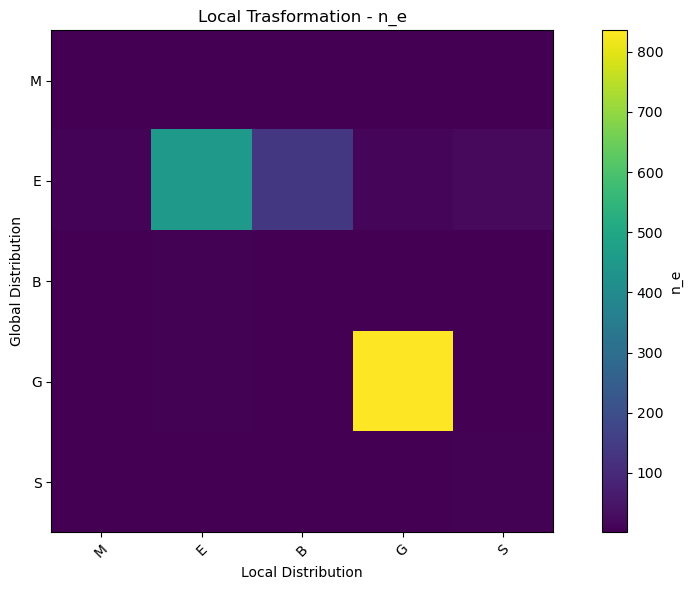

In [68]:
prefix = ""#"nountill_"
tests_acronym = ["M", "E", "B", "G", "S"]
value = "n_e"


plot_tests_vs(tests_acromym=tests_acronym, value=value, prefix=prefix, focus_dict = None, table_name="results")


Correlation Statistics:
------------------------------------------------------------

precomp_E2B:
Number of unique base_xi_id values: 100
Correlation equation: y = -0.0001x + 0.1389
R² = 0.2939
p-value = 5.6852e-09
Standard Error = 0.0000


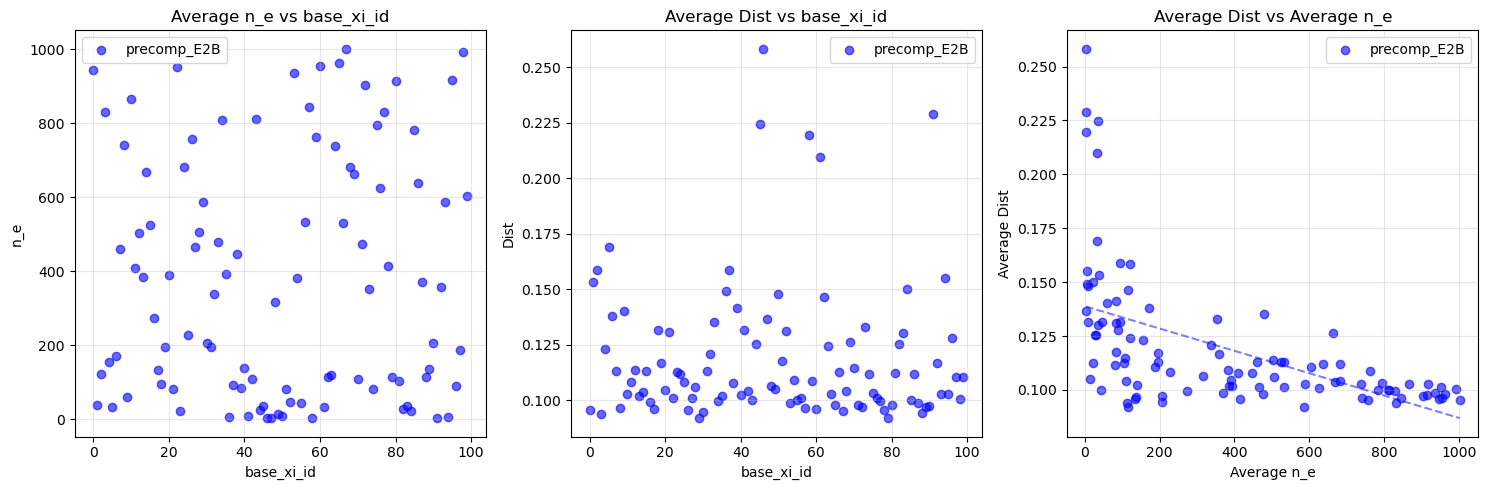

In [30]:
# Computing the average results for each base_xi_id:
#['n_psi_added', 'n_traj', 'local_std', 'n_traj_points', 'phi_id', 'base_xi_id', 'Dist', 'Cos_Dist', 'Dist_rho', 'Norm_glob', 'Norm_loc', 'Norm_imp', 'Pinv_error', 'Sum_weights', 'Sum_squared_weights', 'Elapsed_time', 'Process_mem', 'n_e']

# Example parameters
test_names = ["precomp_E2B"]
column_x = "base_xi_id"
column_y1 = "n_e"
column_y2 = "Dist"

# Optional focus dictionary to filter specific values
#focus_dict = {}

# Create the analysis plots
fig, stats_summary = analyze_column_correlations(
    test_names=test_names,
    column_x=column_x,
    column_y1=column_y1,
    column_y2=column_y2
)

plt.show()
